In [1]:
#!pip download lifelines
#%pip install input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
#%pip install input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
#%pip install input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
#%pip install input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import numpy as np
from tqdm import tqdm

import lightgbm as lgb
from scipy.stats import rankdata 
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from lifelines import KaplanMeierFitter, NelsonAalenFitter
from sklearn.preprocessing import StandardScaler, LabelEncoder
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

test = pd.read_csv("input/data/test.csv")
print("Test shape:", test.shape )

train = pd.read_csv("input/data/train.csv")
print("Train shape:",train.shape)
train.head()

Test shape: (3, 58)
Train shape: (28800, 60)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,ALL,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,Intermediate,MAC,Not Hispanic or Latino,2009,No,Positive,No,Permissive,2.0,No,29.23,No,2.0,No,43.245,2.0,FK+ MMF +- others,No,M-M,2.0,White,0.0,90.0,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,Peripheral blood,No,No,No,MPN,6.0,+/+,10.0,2.0,NaN,5.0,2.0,No,2.0,2.0,PB,NaN,MAC,Hispanic or Latino,2018,No,NaN,Yes,NaN,2.0,No,56.81,No,2.0,No,29.740,2.0,TDEPLETION +- other,No,M-F,2.0,American Indian or Alaska Native,1.0,90.0,No,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


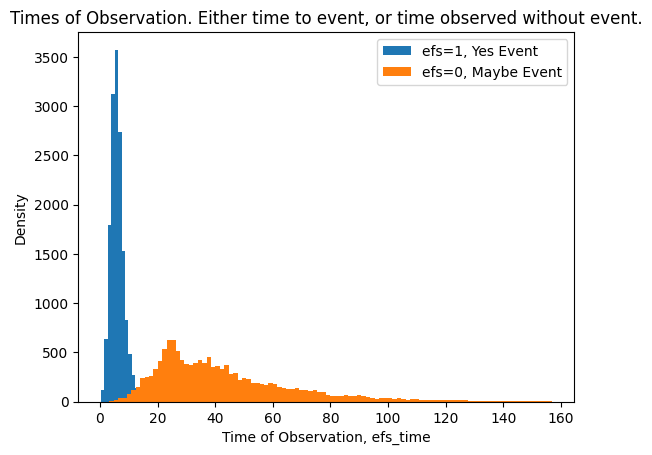

In [3]:
# Train targets
plt.hist(train.loc[train.efs==1,"efs_time"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"efs_time"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Time of Observation, efs_time")
plt.ylabel("Density")
plt.title("Times of Observation. Either time to event, or time observed without event.")
plt.legend()
plt.show()

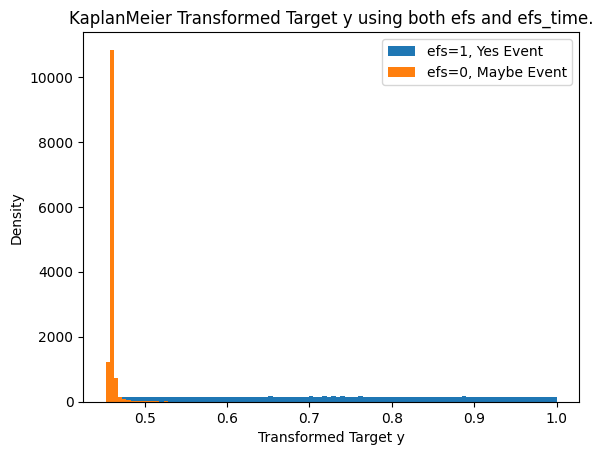

In [4]:
# Transform Two Targets into One Target with KaplanMeier
def transform_survival_probability(df, time_col='efs_time', event_col='efs'):
    kmf = KaplanMeierFitter()
    kmf.fit(df[time_col], df[event_col])
    y = kmf.survival_function_at_times(df[time_col]).values
    return y
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("KaplanMeier Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [5]:
RMV = ["ID","efs","efs_time","y"]
FEATURES = [c for c in train.columns if not c in RMV]
print(f"Number of Features: {len(FEATURES)} FEATURES: {FEATURES}")

Number of Features: 57 FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [6]:
CATS = []
for c in FEATURES:
    if train[c].dtype=="object":
        CATS.append(c)
        train[c] = train[c].fillna("NAN")
        test[c] = test[c].fillna("NAN")
print(f"In these features, there are {len(CATS)} CATEGORICAL FEATURES: {CATS}")

In these features, there are 35 CATEGORICAL FEATURES: ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [7]:
combined = pd.concat([train,test],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

# LABEL ENCODE CATEGORICAL FEATURES
print("We LABEL ENCODE the CATEGORICAL FEATURES: ",end="")
for c in FEATURES:

    # LABEL ENCODE CATEGORICAL AND CONVERT TO INT32 CATEGORY
    if c in CATS:
        print(f"{c}, ",end="")
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        combined[c] = combined[c].astype("category")
        
    # REDUCE PRECISION OF NUMERICAL TO 32BIT TO SAVE MEMORY
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
    
train = combined.iloc[:len(train)].copy()
test = combined.iloc[len(train):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: dri_score, psych_disturb, cyto_score, diabetes, tbi_status, arrhythmia, graft_type, vent_hist, renal_issue, pulm_severe, prim_disease_hct, cmv_status, tce_imm_match, rituximab, prod_type, cyto_score_detail, conditioning_intensity, ethnicity, obesity, mrd_hct, in_vivo_tcd, tce_match, hepatic_severe, prior_tumor, peptic_ulcer, gvhd_proph, rheum_issue, sex_match, race_group, hepatic_mild, tce_div_match, donor_related, melphalan_dose, cardiac, pulm_moderate, 

In [14]:
# PCA 
# Extract the numerical columns to be used in the PCA
train_num = train.drop('ID', axis=1)
test_num = test.drop('ID', axis=1)

# Get numeric and categorical columns
numeric_columns = train.select_dtypes(include=['int32', 'float32']).columns
categorical_columns = train.select_dtypes(exclude=['int32', 'float32']).columns

# Split into numeric and categorical dataframes
train_numeric = train_num[numeric_columns]
test_numeric = test_num[numeric_columns]
train_categorical = train[categorical_columns]
test_categorical = test[categorical_columns]

# Scale the numeric columns
scaler = StandardScaler()
train_scaled = pd.DataFrame(
    scaler.fit_transform(train_numeric),
    columns=train_numeric.columns
)
test_scaled = pd.DataFrame(
    scaler.transform(test_numeric),
    columns=test_numeric.columns
)

# Merge scaled numeric data with categorical data
train_final = pd.concat([train_scaled, train_categorical], axis=1)
test_final = pd.concat([test_scaled, test_categorical], axis=1)

In [15]:
train_final.head()

,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,year_hct,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10,ID,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,cmv_status,tce_imm_match,rituximab,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,obesity,mrd_hct,in_vivo_tcd,tce_match,hepatic_severe,prior_tumor,peptic_ulcer,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate,efs,efs_time,y
0,NaN,NaN,0.709327,0.733688,NaN,0.587754,0.697842,0.556195,0.63089,0.529603,0.260175,0.640967,NaN,0.616327,-1.358153,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,42.356,0.458687
1,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,-2.276400,0.640967,1.952535,0.616327,0.238416,0.634834,0.645742,0.650656,0.559264,0.700679,0.635062,0.709252,1,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,0,0,1,0,1,1,0,1,1,0,0,1,1.0,4.672,0.847759
2,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,1.211391,0.640967,NaN,0.616327,-0.220651,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,2,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,1,1,0,0,0,0.0,19.793,0.462424
3,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,0.697842,0.556195,0.63089,0.529603,-1.959328,0.640967,-0.870858,0.616327,0.216664,0.634834,0.645742,-0.853550,0.559264,0.700679,0.635062,0.709252,3,2,0,1,0,0,0,0,0,0,0,3,0,1,0,0,1,1,0,0,1,1,1,0,0,0,3,0,3,2,1,1,0,0,0,0,0.0,102.349,0.456661
4,0.545187,0.71803,0.709327,0.733688,0.725833,0.587754,-0.133265,0.556195,0.63089,0.529603,0.894319,0.640967,0.937530,0.616327,-0.421955,0.634834,0.645742,-0.352148,0.559264,0.700679,0.635062,0.709252,4,2,0,0,0,0,0,1,0,0,0,4,0,0,0,1,0,1,1,0,0,0,0,0,0,0,4,0,0,3,0,1,1,1,0,0,0.0,16.223,0.464674


In [16]:
test = test_final
train = train_final

In [17]:
# XGBoost with KaplanMeier
print("Using XGBoost version",xgb.__version__)

Using XGBoost version 2.1.3


In [18]:
%%time
FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
    
oof_xgb = np.zeros(len(train))
pred_xgb = np.zeros(len(test))

for i, (train_index, test_index) in enumerate(kf.split(train)):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)
    
    x_train = train.loc[train_index,FEATURES].copy()
    y_train = train.loc[train_index,"y"]
    x_valid = train.loc[test_index,FEATURES].copy()
    y_valid = train.loc[test_index,"y"]
    x_test = test[FEATURES].copy()

    model_xgb = XGBRegressor(
        device="cuda",
        max_depth=3,  
        colsample_bytree=0.5,  
        subsample=0.8,  
        n_estimators=2000,  
        learning_rate=0.02,  
        enable_categorical=True,
        min_child_weight=80,
        #early_stopping_rounds=25,
    )
    model_xgb.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],  
        verbose=500 
    )

    # INFER OOF
    oof_xgb[test_index] = model_xgb.predict(x_valid)
    # INFER TEST
    pred_xgb += model_xgb.predict(x_test)

# COMPUTE AVERAGE TEST PREDS
pred_xgb /= FOLDS

#########################
### Fold 1
#########################
[0]	validation_0-rmse:0.17783
[500]	validation_0-rmse:0.15962
[1000]	validation_0-rmse:0.15752
[1500]	validation_0-rmse:0.15660
[1999]	validation_0-rmse:0.15609
#########################
### Fold 2
#########################
[0]	validation_0-rmse:0.17363
[500]	validation_0-rmse:0.15573
[1000]	validation_0-rmse:0.15416
[1500]	validation_0-rmse:0.15352
[1999]	validation_0-rmse:0.15314
#########################
### Fold 3
#########################
[0]	validation_0-rmse:0.17735
[500]	validation_0-rmse:0.15801
[1000]	validation_0-rmse:0.15616
[1500]	validation_0-rmse:0.15545
[1999]	validation_0-rmse:0.15505
#########################
### Fold 4
#########################
[0]	validation_0-rmse:0.17931
[500]	validation_0-rmse:0.16008
[1000]	validation_0-rmse:0.15799
[1500]	validation_0-rmse:0.15713
[1999]	validation_0-rmse:0.15666
#########################
### Fold 5
#########################
[0]	validation_0-rmse:0.17376
[500]	valid